In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import ray
import time

"""
ray actor experiment description:
    creates 'num_actors' ray actors
    for n from 1 to 'num_actors', with step size 'actor_step_size':
        run n of the actors in parallel, each doing 'num_operations' operations
        record the time it takes
    graph time vs n
to test for different 'num_cpus' options, must restart notebook because cannot call ray.init twice
"""

#experiment parameters
num_cpus = 64

#num_actors: set to see behavior as num_actors exceeds a multiple of num_cpus
num_actors = num_cpus + 20 
#num_actors = num_cpus * 20 + 20

#actor_step_size: on each step, run this many more actors simultaneously
#for larger num_cpus, should decrease this so tests do not run forever
actor_step_size = 8 

num_operations = 5

ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
@ray.remote
class TestActor(object):
    def __init__(self):
        self.counter = 0

    def reset(self):
        self.counter = 0

    def increment(self):
        time.sleep(0.5)
        self.counter += 1
        return self.counter

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:45057 to respond...
Waiting for redis server at 127.0.0.1:13561 to respond...
Starting the Plasma object store with 6.00 GB memory.
Starting local scheduler with the following resources: {'CPU': 64, 'GPU': 0}.

View the web UI at http://localhost:8889/notebooks/ray_ui8783.ipynb?token=9e9a4abbc91a0114a9f3b355b1bcaca617ee3f45f3c052aa



In [3]:
number_curr_actors = [int(i*actor_step_size) for i in range(1, int(num_actors/actor_step_size))]
ray_actors = [TestActor.remote() for i in range(num_actors)]
time.sleep(15) # make sure the actors are all instantiated before running the tests
times = []
for n in number_curr_actors:
    curr_ray_actors = ray_actors[:n]
    
    for curr_actor in curr_ray_actors:
        curr_actor.reset.remote()

    results = []
    for _ in range(num_operations):
        for curr_actor in curr_ray_actors:
            results.append(curr_actor.increment.remote())
    start_time = time.time()
    results = ray.get(results)
    duration = time.time() - start_time
    times.append(duration)

The actor with ID 871e5649ac2c9e962a97aa7fe66bd53fa9bbc8d1 is taking a while to be created. It is possible that the cluster does not have enough resources to place this actor (this may be normal while an autoscaling is scaling up). Consider reducing the number of actors created, or increasing the number of slots available by using the --num-cpus, --num-gpus, and --resources flags. The actor creation task is requesting 0 CPU 
The actor with ID 957e7fbcdd0cc067d3d5fb70dbf6370b09267d0e is taking a while to be created. It is possible that the cluster does not have enough resources to place this actor (this may be normal while an autoscaling is scaling up). Consider reducing the number of actors created, or increasing the number of slots available by using the --num-cpus, --num-gpus, and --resources flags. The actor creation task is requesting 0 CPU 


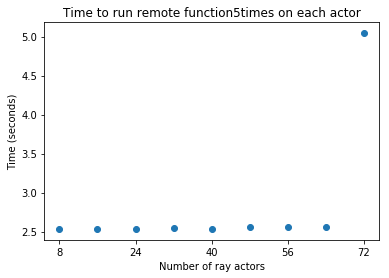

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(number_curr_actors, times)
plt.xticks(number_curr_actors[::2])
plt.xlabel("Number of ray actors")
plt.ylabel("Time (seconds)")
plt.title("Time to run remote function" + str(num_operations) + "times on each actor")